In [1]:
import os
import sys
import warnings
from datetime import date

import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
from numpy import cumsum, log, polyfit, sqrt, std, subtract

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.cm as cm
import seaborn as sns

from scipy.stats import spearmanr, pearsonr
from scipy.stats import probplot, moment

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

from sklearn.metrics import mean_squared_error, mean_absolute_error

C:\Users\amit\AppData\Roaming\Python\Python38\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\amit\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\amit\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [54]:
from datetime import datetime, date, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set(style='darkgrid', context='notebook', color_codes=True)

In [4]:
df=pd.read_csv("Y:/Time Series/Projects/Fish oil/Final_data.csv")
df.head()

date  fishoil_price_peru  rapeseedoil_price_global  \
0  01-12-21              2907.3                   1742.50   
1  01-11-21              3074.3                   1825.34   
2  01-10-21              2641.1                   1795.17   
3  01-09-21              2761.9                   1629.14   
4  01-08-21              2237.2                   1519.19   

   fishmeal_price_peru  peanutoil_price_global  soybeanoil_price_global  \
0              1422.52                 2154.06                  1411.21   
1              1439.66                 2150.21                  1442.96   
2              1461.66                 2133.67                  1483.52   
3              1483.27                 2109.02                  1398.75   
4              1504.12                 2102.29                  1433.94   

   sunfloweroil_price_global  temperature_peru  precipitation_peru  \
0                    1361.83             20.56              157.86   
1                    1415.62             20.42              137.36   
2                    1420.53             20.01              114.61   
3                    1309.52             20.05               64.80   
4                    1355.69             19.44               53.05   

   fish_production_peru  fish_human_consumption_peru  \
0                   5.8                        33.97   
1                   5.8                        32.41   
2                   5.8                        32.12   
3                   5.6                        27.83   
4                   5.3                        27.05   

   fish_industrial_consumption_peru     gdp  fishoil_export_peru  \
0                           1082.07  194.30                 5.75   
1                            917.78  168.51                 6.69   
2                              1.26   49.26                 9.30   
3                              0.12   37.47                13.46   
4                              2.53   42.79                30.12   

   fishoil_fob_peru  fishoil_utilization_indicators  
0             16.71                           63.54  
1             20.55                           51.51  
2             24.56                            0.06  
3             37.17                            0.01  
4             67.39                            0.14

In [5]:
# Simplify column names
df.columns = ["date",'peru_price', 'rapeseed_oil', 'fish_meal', 'peanut_oil',"soyabean_oil",'sunflower_oil',"peru_temperature","peru_precipitation","peru_fish_production","fish_human_consumption","fish_industrial_consumption","gdp", "fish_oil_export","transporation_FOB","fishoil_utilization_indicators"]
targets = ['peru_price']
features = [feature for feature in df.columns if feature not in targets]

In [6]:
df['date'] = pd.to_datetime(df['date'], format = '%d-%m-%y')
df.head()

date  peru_price  rapeseed_oil  fish_meal  peanut_oil  soyabean_oil  \
0 2021-12-01      2907.3       1742.50    1422.52     2154.06       1411.21   
1 2021-11-01      3074.3       1825.34    1439.66     2150.21       1442.96   
2 2021-10-01      2641.1       1795.17    1461.66     2133.67       1483.52   
3 2021-09-01      2761.9       1629.14    1483.27     2109.02       1398.75   
4 2021-08-01      2237.2       1519.19    1504.12     2102.29       1433.94   

   sunflower_oil  peru_temperature  peru_precipitation  peru_fish_production  \
0        1361.83             20.56              157.86                   5.8   
1        1415.62             20.42              137.36                   5.8   
2        1420.53             20.01              114.61                   5.8   
3        1309.52             20.05               64.80                   5.6   
4        1355.69             19.44               53.05                   5.3   

   fish_human_consumption  fish_industrial_consumption     gdp  \
0                   33.97                      1082.07  194.30   
1                   32.41                       917.78  168.51   
2                   32.12                         1.26   49.26   
3                   27.83                         0.12   37.47   
4                   27.05                         2.53   42.79   

   fish_oil_export  transporation_FOB  fishoil_utilization_indicators  
0             5.75              16.71                           63.54  
1             6.69              20.55                           51.51  
2             9.30              24.56                            0.06  
3            13.46              37.17                            0.01  
4            30.12              67.39                            0.14

In [7]:
end = datetime(2002,12,1)
df = df[df["date"] > end] 
df.tail(5)

date  peru_price  rapeseed_oil  fish_meal  peanut_oil  soyabean_oil  \
223 2003-05-01       414.2        607.17     630.09     1147.41        549.24   
224 2003-04-01       636.1        557.22     601.92     1064.23        540.90   
225 2003-03-01       589.4        551.92     620.43     1039.32        522.52   
226 2003-02-01       449.8        585.76     629.46     1016.45        522.43   
227 2003-01-01       499.1        623.72     639.75      970.03        540.72   

     sunflower_oil  peru_temperature  peru_precipitation  \
223          595.0             19.05              161.21   
224          578.0             19.64              143.62   
225          565.0             20.65              203.28   
226          595.0             20.83              220.07   
227          612.0             20.85              179.45   

     peru_fish_production  fish_human_consumption  \
223                  1.44                   30.91   
224                  1.18                   23.15   
225                  1.28                   24.97   
226                  1.42                   24.69   
227                  1.19                   40.24   

     fish_industrial_consumption     gdp  fish_oil_export  transporation_FOB  \
223                      1088.91  116.35            37.55              15.55   
224                      1281.71  131.75             0.64               0.41   
225                        66.73   27.33             1.43               0.84   
226                        80.92   27.52            16.85               7.58   
227                        39.69   32.79            10.08               5.03   

     fishoil_utilization_indicators  
223                           37.58  
224                           44.74  
225                            2.44  
226                            2.71  
227                            1.36

In [8]:
df.isna().sum()

date                              0
peru_price                        0
rapeseed_oil                      0
fish_meal                         0
peanut_oil                        0
soyabean_oil                      0
sunflower_oil                     0
peru_temperature                  0
peru_precipitation                0
peru_fish_production              0
fish_human_consumption            0
fish_industrial_consumption       0
gdp                               0
fish_oil_export                   0
transporation_FOB                 0
fishoil_utilization_indicators    0
dtype: int64

### Shifting time series

In [9]:
def get_year(x):
    return x.year

In [10]:
def get_month(x):
    return x.month

In [11]:
df["year"] = df["date"].apply(lambda x : x.year)
df["month"] = df["date"].apply(lambda x : x.month)
df.head()

date  peru_price  rapeseed_oil  fish_meal  peanut_oil  soyabean_oil  \
0 2021-12-01      2907.3       1742.50    1422.52     2154.06       1411.21   
1 2021-11-01      3074.3       1825.34    1439.66     2150.21       1442.96   
2 2021-10-01      2641.1       1795.17    1461.66     2133.67       1483.52   
3 2021-09-01      2761.9       1629.14    1483.27     2109.02       1398.75   
4 2021-08-01      2237.2       1519.19    1504.12     2102.29       1433.94   

   sunflower_oil  peru_temperature  peru_precipitation  peru_fish_production  \
0        1361.83             20.56              157.86                   5.8   
1        1415.62             20.42              137.36                   5.8   
2        1420.53             20.01              114.61                   5.8   
3        1309.52             20.05               64.80                   5.6   
4        1355.69             19.44               53.05                   5.3   

   fish_human_consumption  fish_industrial_consumption     gdp  \
0                   33.97                      1082.07  194.30   
1                   32.41                       917.78  168.51   
2                   32.12                         1.26   49.26   
3                   27.83                         0.12   37.47   
4                   27.05                         2.53   42.79   

   fish_oil_export  transporation_FOB  fishoil_utilization_indicators  year  \
0             5.75              16.71                           63.54  2021   
1             6.69              20.55                           51.51  2021   
2             9.30              24.56                            0.06  2021   
3            13.46              37.17                            0.01  2021   
4            30.12              67.39                            0.14  2021   

   month  
0     12  
1     11  
2     10  
3      9  
4      8

In [12]:
graph = df[df["year"]>2016]

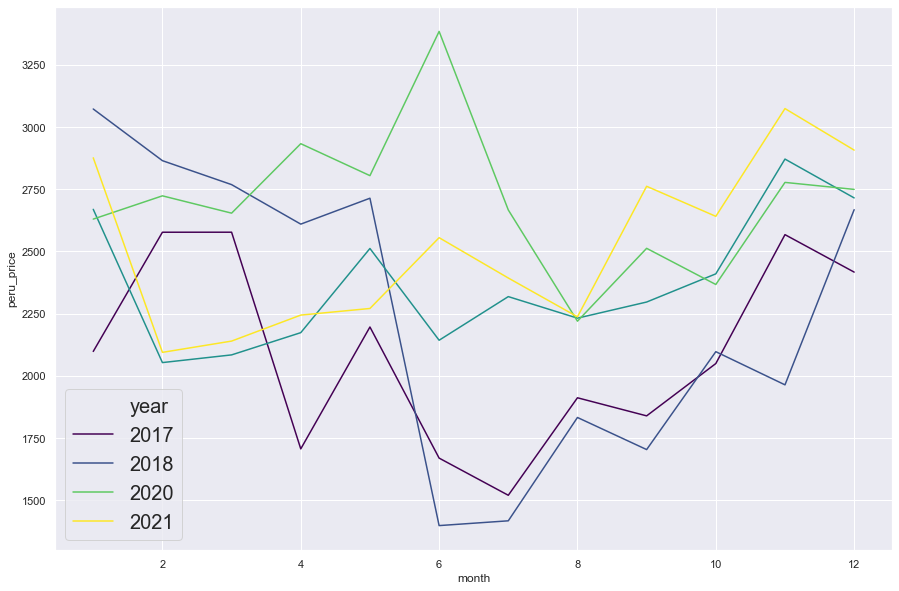

In [13]:
plt.figure(figsize=(15,10))
sns.lineplot(x="month",y="peru_price",data=graph,hue="year",palette="viridis")
plt.legend(fontsize=20)
plt.show()

In [14]:
df.set_index("date", inplace = True)

In [15]:
df = df[::-1]
df.drop(["year","month"],axis = 1, inplace = True)
df.head()

peru_price  rapeseed_oil  fish_meal  peanut_oil  soyabean_oil  \
date                                                                        
2003-01-01       499.1        623.72     639.75      970.03        540.72   
2003-02-01       449.8        585.76     629.46     1016.45        522.43   
2003-03-01       589.4        551.92     620.43     1039.32        522.52   
2003-04-01       636.1        557.22     601.92     1064.23        540.90   
2003-05-01       414.2        607.17     630.09     1147.41        549.24   

            sunflower_oil  peru_temperature  peru_precipitation  \
date                                                              
2003-01-01          612.0             20.85              179.45   
2003-02-01          595.0             20.83              220.07   
2003-03-01          565.0             20.65              203.28   
2003-04-01          578.0             19.64              143.62   
2003-05-01          595.0             19.05              161.21   

            peru_fish_production  fish_human_consumption  \
date                                                       
2003-01-01                  1.19                   40.24   
2003-02-01                  1.42                   24.69   
2003-03-01                  1.28                   24.97   
2003-04-01                  1.18                   23.15   
2003-05-01                  1.44                   30.91   

            fish_industrial_consumption     gdp  fish_oil_export  \
date                                                               
2003-01-01                        39.69   32.79            10.08   
2003-02-01                        80.92   27.52            16.85   
2003-03-01                        66.73   27.33             1.43   
2003-04-01                      1281.71  131.75             0.64   
2003-05-01                      1088.91  116.35            37.55   

            transporation_FOB  fishoil_utilization_indicators  
date                                                           
2003-01-01               5.03                            1.36  
2003-02-01               7.58                            2.71  
2003-03-01               0.84                            2.44  
2003-04-01               0.41                           44.74  
2003-05-01              15.55                           37.58

## Helper Functions

### Hurst Exponent

In [16]:
def hurst(ts):
    lags = range(2, 100)
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(log(lags), log(tau), 1)
    return poly[0]*2.0

### Durbin Watson Test

In [19]:
def durbin_watson_test(df=None, resid=None):
    cols, stat = [], []
    out = durbin_watson(resid)
    for col, val in zip(df.columns, out):
        cols.append(col)
        stat.append(round(val, 2))
    dw_test = pd.DataFrame(stat, index=cols)
    return dw_test

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 228 entries, 2003-01-01 to 2021-12-01
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   peru_price                      228 non-null    float64
 1   rapeseed_oil                    228 non-null    float64
 2   fish_meal                       228 non-null    float64
 3   peanut_oil                      228 non-null    float64
 4   soyabean_oil                    228 non-null    float64
 5   sunflower_oil                   228 non-null    float64
 6   peru_temperature                228 non-null    float64
 7   peru_precipitation              228 non-null    float64
 8   peru_fish_production            228 non-null    float64
 9   fish_human_consumption          228 non-null    float64
 10  fish_industrial_consumption     228 non-null    float64
 11  gdp                             228 non-null    float64
 12  fish_oil_export  

### Plot Series

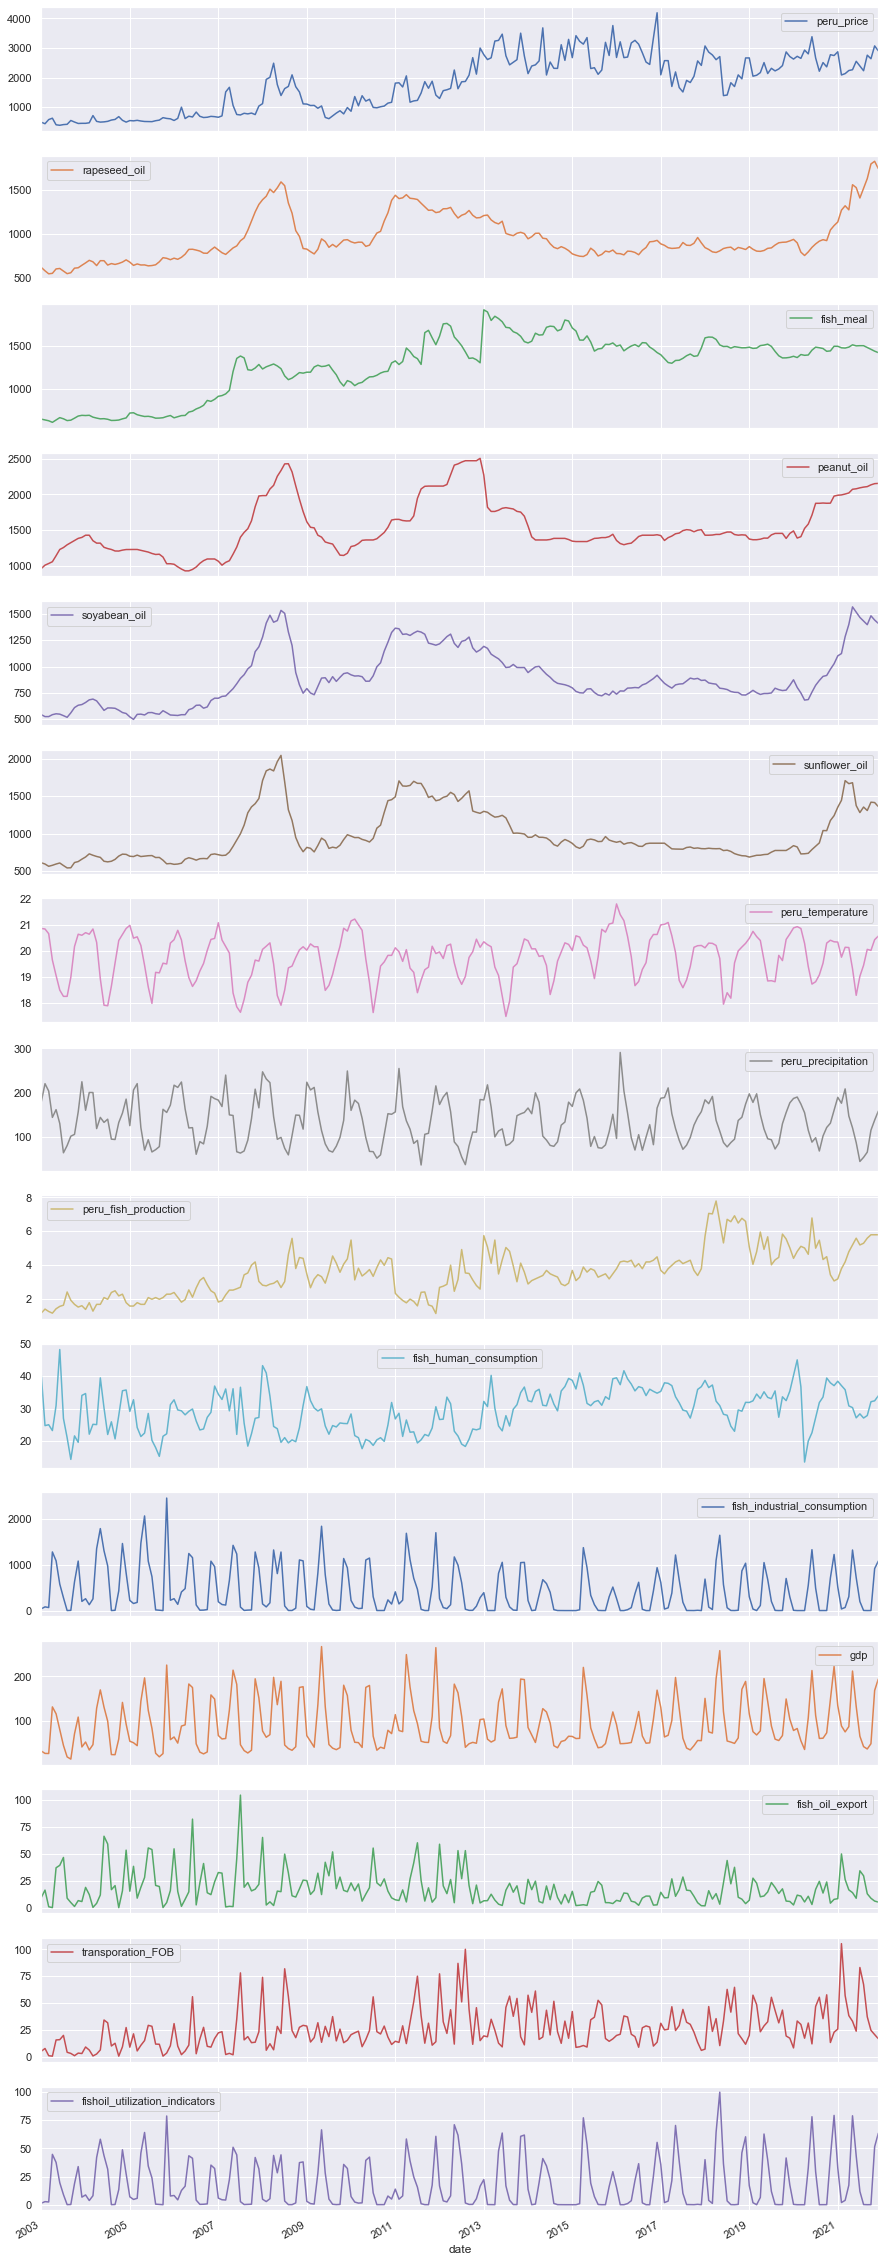

In [21]:
df.plot(subplots=True, figsize=(15,45));

### EDA

### Correlation pair wise

<Figure size 3600x3600 with 0 Axes>

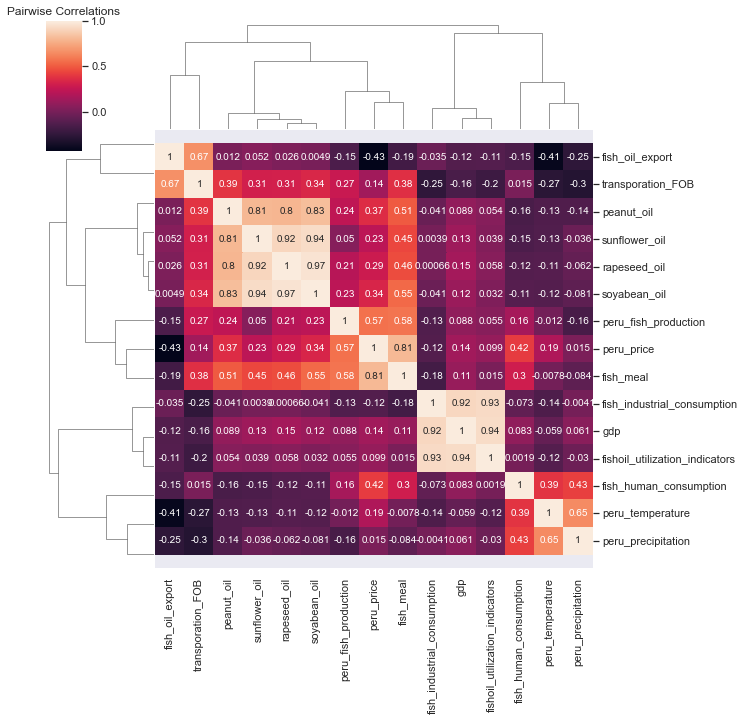

In [22]:
plt.figure(figsize=(50,50))
g = sns.clustermap(df.corr(), annot=True,annot_kws={"fontsize":10})
ax = g.ax_heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pairwise Correlations')
plt.show()

### Testing Causation using Granger’s Causality Test

In [23]:
'''
The Granger causality test is a statistical hypothesis test for determining
whether one time series is useful in forecasting another. Ordinarily, 
regressions reflect "mere" correlations, but Clive Granger argued that causality
in economics could be tested for by measuring the ability to predict the
future values of a time series using prior values of another time series.
Since the question of "true causality" is deeply philosophical, and because
of the post hoc fallacy of assuming that one thing preceding another can be
used as a proof of causation, econometricians assert that the Granger test 
finds only "predictive causality". Rather than testing whether Y causes X,
the Granger causality tests whether Y forecasts X.
'''

'\nThe Granger causality test is a statistical hypothesis test for determining\nwhether one time series is useful in forecasting another. Ordinarily, \nregressions reflect "mere" correlations, but Clive Granger argued that causality\nin economics could be tested for by measuring the ability to predict the\nfuture values of a time series using prior values of another time series.\nSince the question of "true causality" is deeply philosophical, and because\nof the post hoc fallacy of assuming that one thing preceding another can be\nused as a proof of causation, econometricians assert that the Granger test \nfinds only "predictive causality". Rather than testing whether Y causes X,\nthe Granger causality tests whether Y forecasts X.\n'

In [24]:
'''
In simpler terms, the past values of time series (X) do not cause the
other series (Y). So, if the p-value obtained from the test is lesser 
than the significance level of 0.05, then, you can safely reject the null
hypothesis.

The below code implements the Granger’s Causality test for all possible
combinations of each time series in a given dataframe and stores the
p-values of each combination in matrix form.
'''

'\nIn simpler terms, the past values of time series (X) do not cause the\nother series (Y). So, if the p-value obtained from the test is lesser \nthan the significance level of 0.05, then, you can safely reject the null\nhypothesis.\n\nThe below code implements the Granger’s Causality test for all possible\ncombinations of each time series in a given dataframe and stores the\np-values of each combination in matrix form.\n'

In [25]:
maxlag = 12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False): 
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

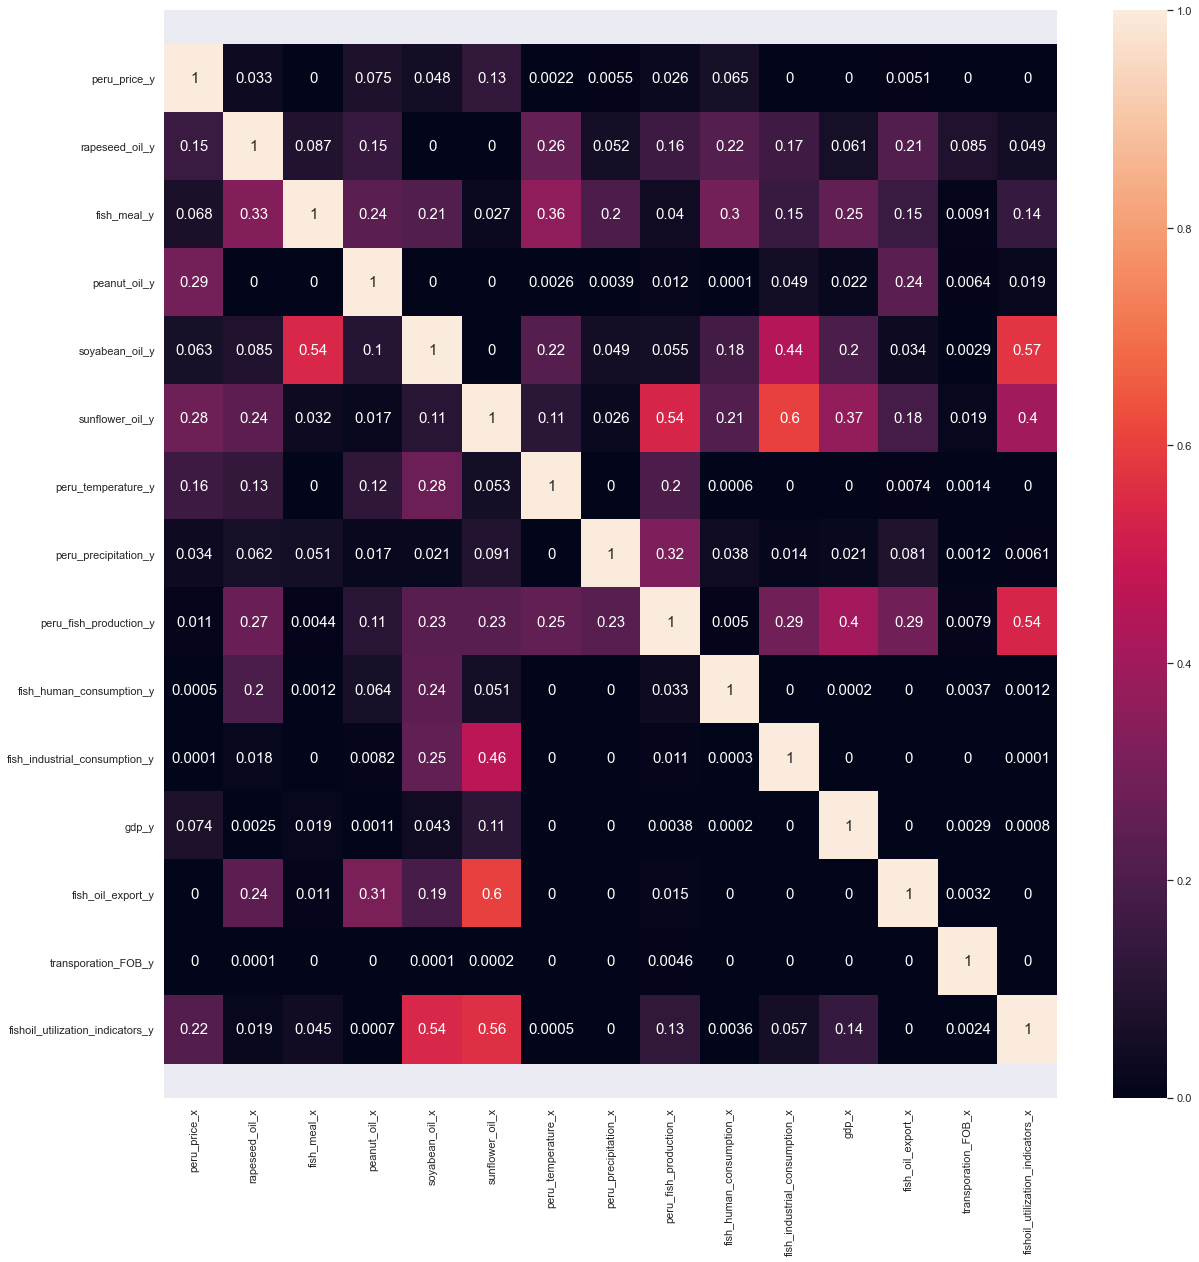

In [26]:
grangers_df = grangers_causation_matrix(df, variables = df.columns) 

plt.figure(figsize=(20,20))
sns.heatmap(grangers_df, annot=True,annot_kws={"fontsize":15})
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show()

### Find Significant Pairs in a p-value matrix

In [27]:
pairs = grangers_df.unstack()
pairs = pairs.sort_values(kind="quicksort")
mask = pairs < 0.05

print("Significan Pairs")
print(pairs[mask])

Significan Pairs
fishoil_utilization_indicators_x  peru_price_y                        0.0000
fish_industrial_consumption_x     transporation_FOB_y                 0.0000
fish_meal_x                       peru_price_y                        0.0000
fish_industrial_consumption_x     fish_oil_export_y                   0.0000
peru_precipitation_x              peru_temperature_y                  0.0000
                                                                       ...  
fish_meal_x                       fishoil_utilization_indicators_y    0.0455
soyabean_oil_x                    peru_price_y                        0.0476
fish_industrial_consumption_x     peanut_oil_y                        0.0490
peru_precipitation_x              soyabean_oil_y                      0.0491
fishoil_utilization_indicators_x  rapeseed_oil_y                      0.0494
Length: 124, dtype: float64


In [28]:
#Looking at the P-Values in the above table, you can pretty much observe that most the variables (time series) in the system are interchangeably causing each other. This makes this system of multi time series a good candidate for using VAR models to forecast.

### Cointegration Test

In [29]:
'''
Cointegration test helps to establish the presence of a statistically significant connection between two or more
time series. Cointegration is a statistical property of two or more time-series variables which indicates if a linear 
combination of the variables is stationary.

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.

This is the basic premise on which Vector Autoregression(VAR) models is based on. So it is common to implement the 
cointegration test before starting to build VAR models.
'''

'\nCointegration test helps to establish the presence of a statistically significant connection between two or more\ntime series. Cointegration is a statistical property of two or more time-series variables which indicates if a linear \ncombination of the variables is stationary.\n\nWhen two or more time series are cointegrated, it means they have a long run, statistically significant relationship.\n\nThis is the basic premise on which Vector Autoregression(VAR) models is based on. So it is common to implement the \ncointegration test before starting to build VAR models.\n'

In [30]:
def find_cointegrated_pairs(dataframe, critial_level = 0.05):
    n = dataframe.shape[1] 
    pvalue_matrix = np.ones((n, n)) 
    keys = dataframe.columns 
    pairs = [] 
    for i in range(n):
        for j in range(i+1, n): 
            series1 = dataframe[keys[i]] 
            series2 = dataframe[keys[j]]
            result = sm.tsa.stattools.coint(series1, series2) 
            pvalue = result[1] 
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level: 
                pairs.append((keys[i], keys[j], pvalue)) 
    return pvalue_matrix, pairs

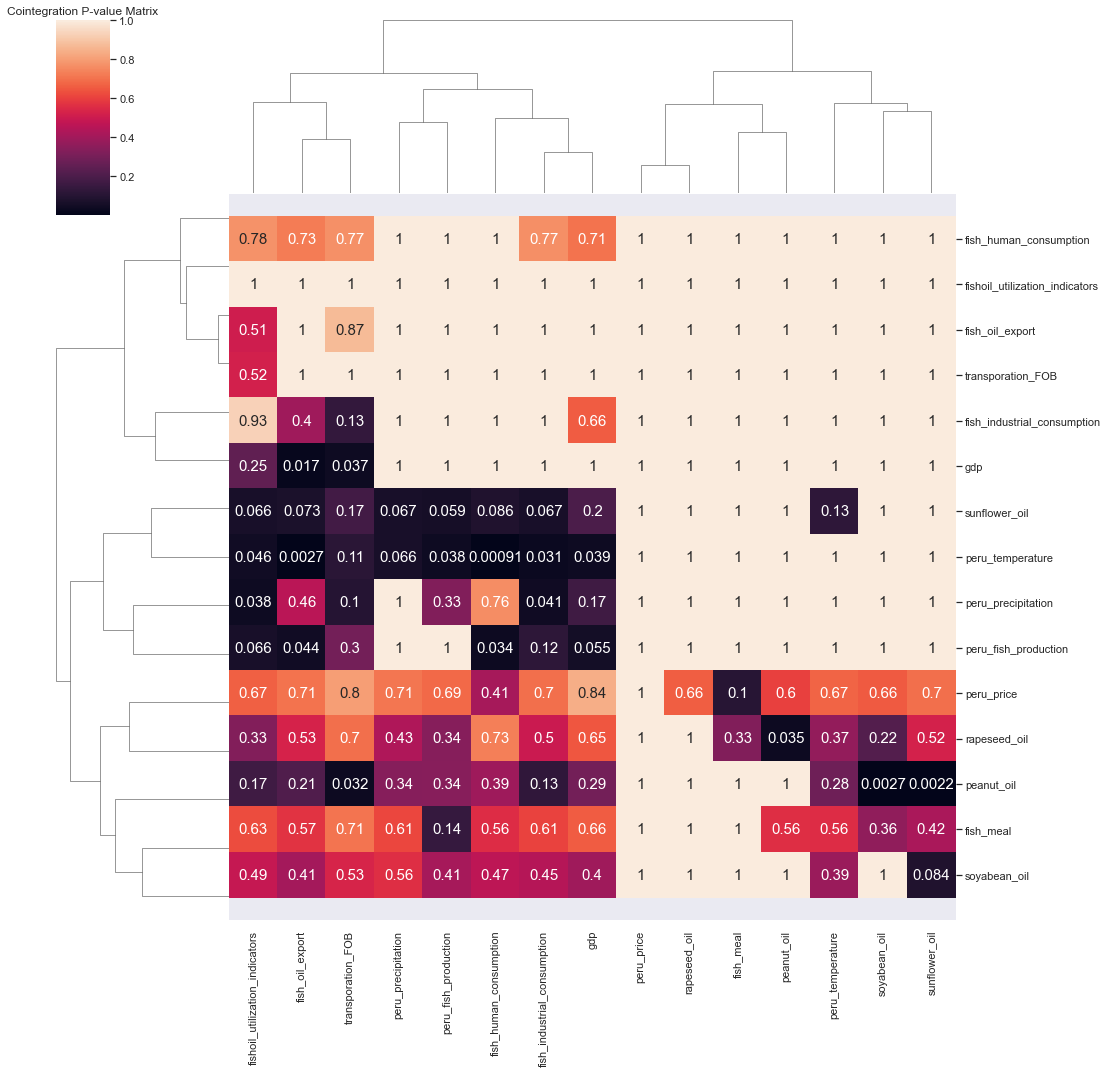

In [31]:
pvalue_matrix, pairs = find_cointegrated_pairs(df)
coint_pvalue_matrix_df = pd.DataFrame(pvalue_matrix)

g = sns.clustermap(coint_pvalue_matrix_df, xticklabels=df.columns,yticklabels=df.columns, annot=True, 
                   figsize=(15, 15),annot_kws={"fontsize":15})
plt.title('Cointegration P-value Matrix')
ax = g.ax_heatmap
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [32]:
pairs

[('rapeseed_oil', 'peanut_oil', 0.03508992310953115),
 ('peanut_oil', 'soyabean_oil', 0.0026853034312980316),
 ('peanut_oil', 'sunflower_oil', 0.0022140353797906755),
 ('peanut_oil', 'transporation_FOB', 0.03240197333689153),
 ('peru_temperature', 'peru_fish_production', 0.037658686174938255),
 ('peru_temperature', 'fish_human_consumption', 0.0009063385771115584),
 ('peru_temperature', 'fish_industrial_consumption', 0.03121762557531741),
 ('peru_temperature', 'gdp', 0.03872748439670391),
 ('peru_temperature', 'fish_oil_export', 0.0027390230775060703),
 ('peru_temperature', 'fishoil_utilization_indicators', 0.046143079182929356),
 ('peru_precipitation', 'fish_industrial_consumption', 0.040605594773221725),
 ('peru_precipitation', 'fishoil_utilization_indicators', 0.03777624992865804),
 ('peru_fish_production', 'fish_human_consumption', 0.03447484278241159),
 ('peru_fish_production', 'fish_oil_export', 0.0441205963765048),
 ('gdp', 'fish_oil_export', 0.016567320132006052),
 ('gdp', 'tran

In [33]:
#Peru_price is not pair with anything

### Time Series Decomposition

In [34]:
for column in df.columns:
    decomp=seasonal_decompose(df[column],period = 12,model="additive", extrapolate_trend="freq")
    df[f"{column}_trend"]=decomp.trend
    df[f"{column}_seasonal"]=decomp.seasonal

In [35]:
core_column = ['peru_price', 'rapeseed_oil', 'fish_meal', 'peanut_oil',"soyabean_oil",'sunflower_oil',"peru_temperature","peru_precipitation","peru_fish_production","fish_human_consumption","fish_industrial_consumption","gdp", "fish_oil_export","transporation_FOB","fishoil_utilization_indicators"]
core_column_1 = ['peru_price', 'rapeseed_oil', 'fish_meal', 'peanut_oil',"soyabean_oil",'sunflower_oil',"peru_temperature","peru_precipitation"]
core_column_2 = ["peru_fish_production","fish_human_consumption","fish_industrial_consumption","gdp", "fish_oil_export","transporation_FOB","fishoil_utilization_indicators"]

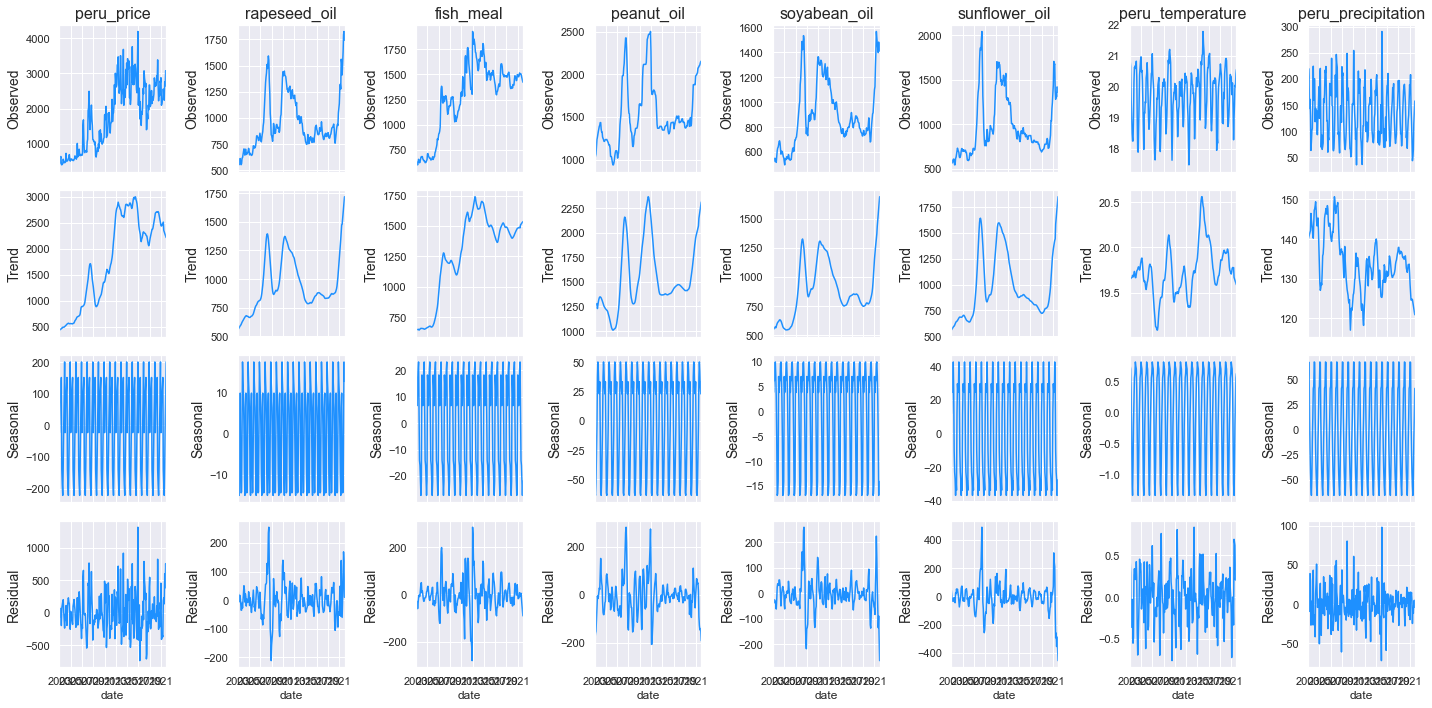

In [36]:
fig,ax=plt.subplots(ncols=8,nrows=4,sharex=True,figsize=(20,10))
for i, column in enumerate(core_column_1):
    
    res = seasonal_decompose(df[column], freq=12, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('{}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)
plt.tight_layout()
plt.show()

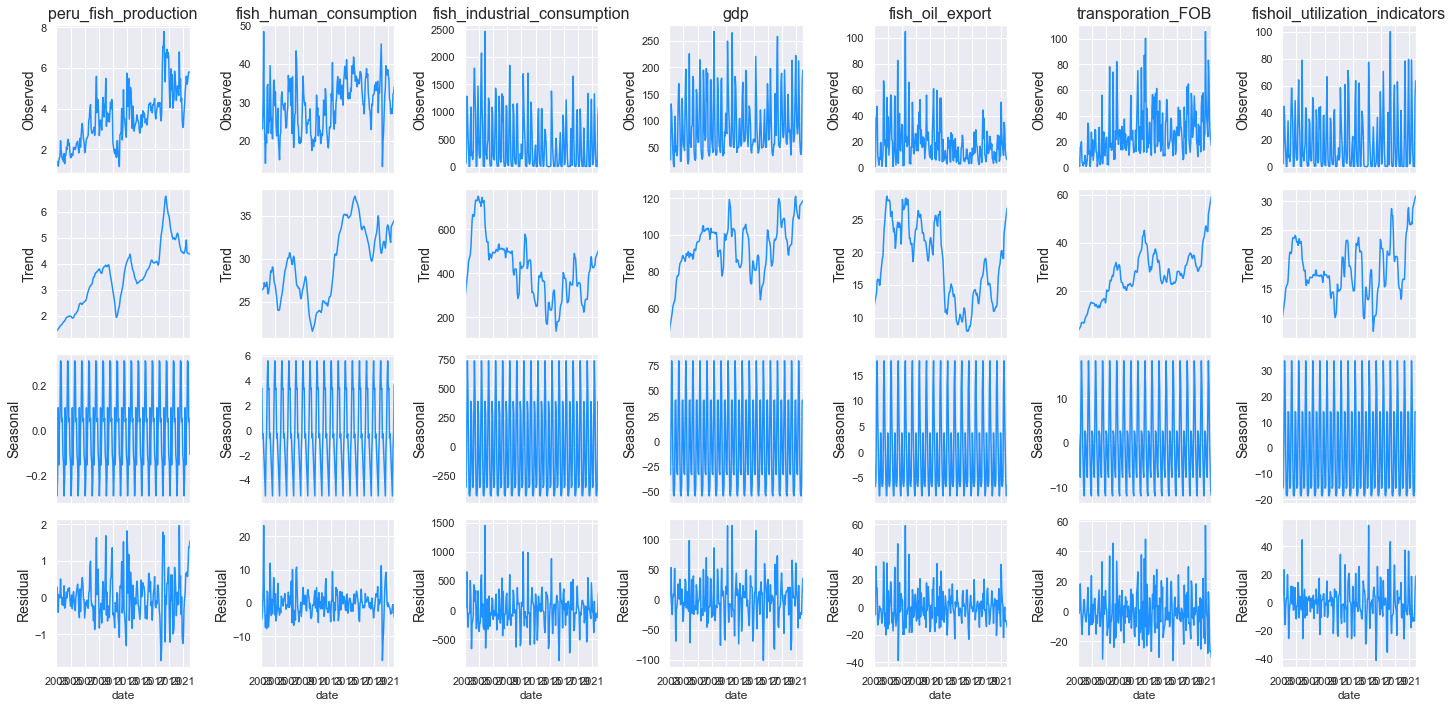

In [37]:
fig,ax=plt.subplots(ncols=7,nrows=4,sharex=True,figsize=(20,10))
for i, column in enumerate(core_column_2):
    
    res = seasonal_decompose(df[column], freq=12, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('{}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)
plt.tight_layout()
plt.show()

### Calculating correlation between variables based on seasonality

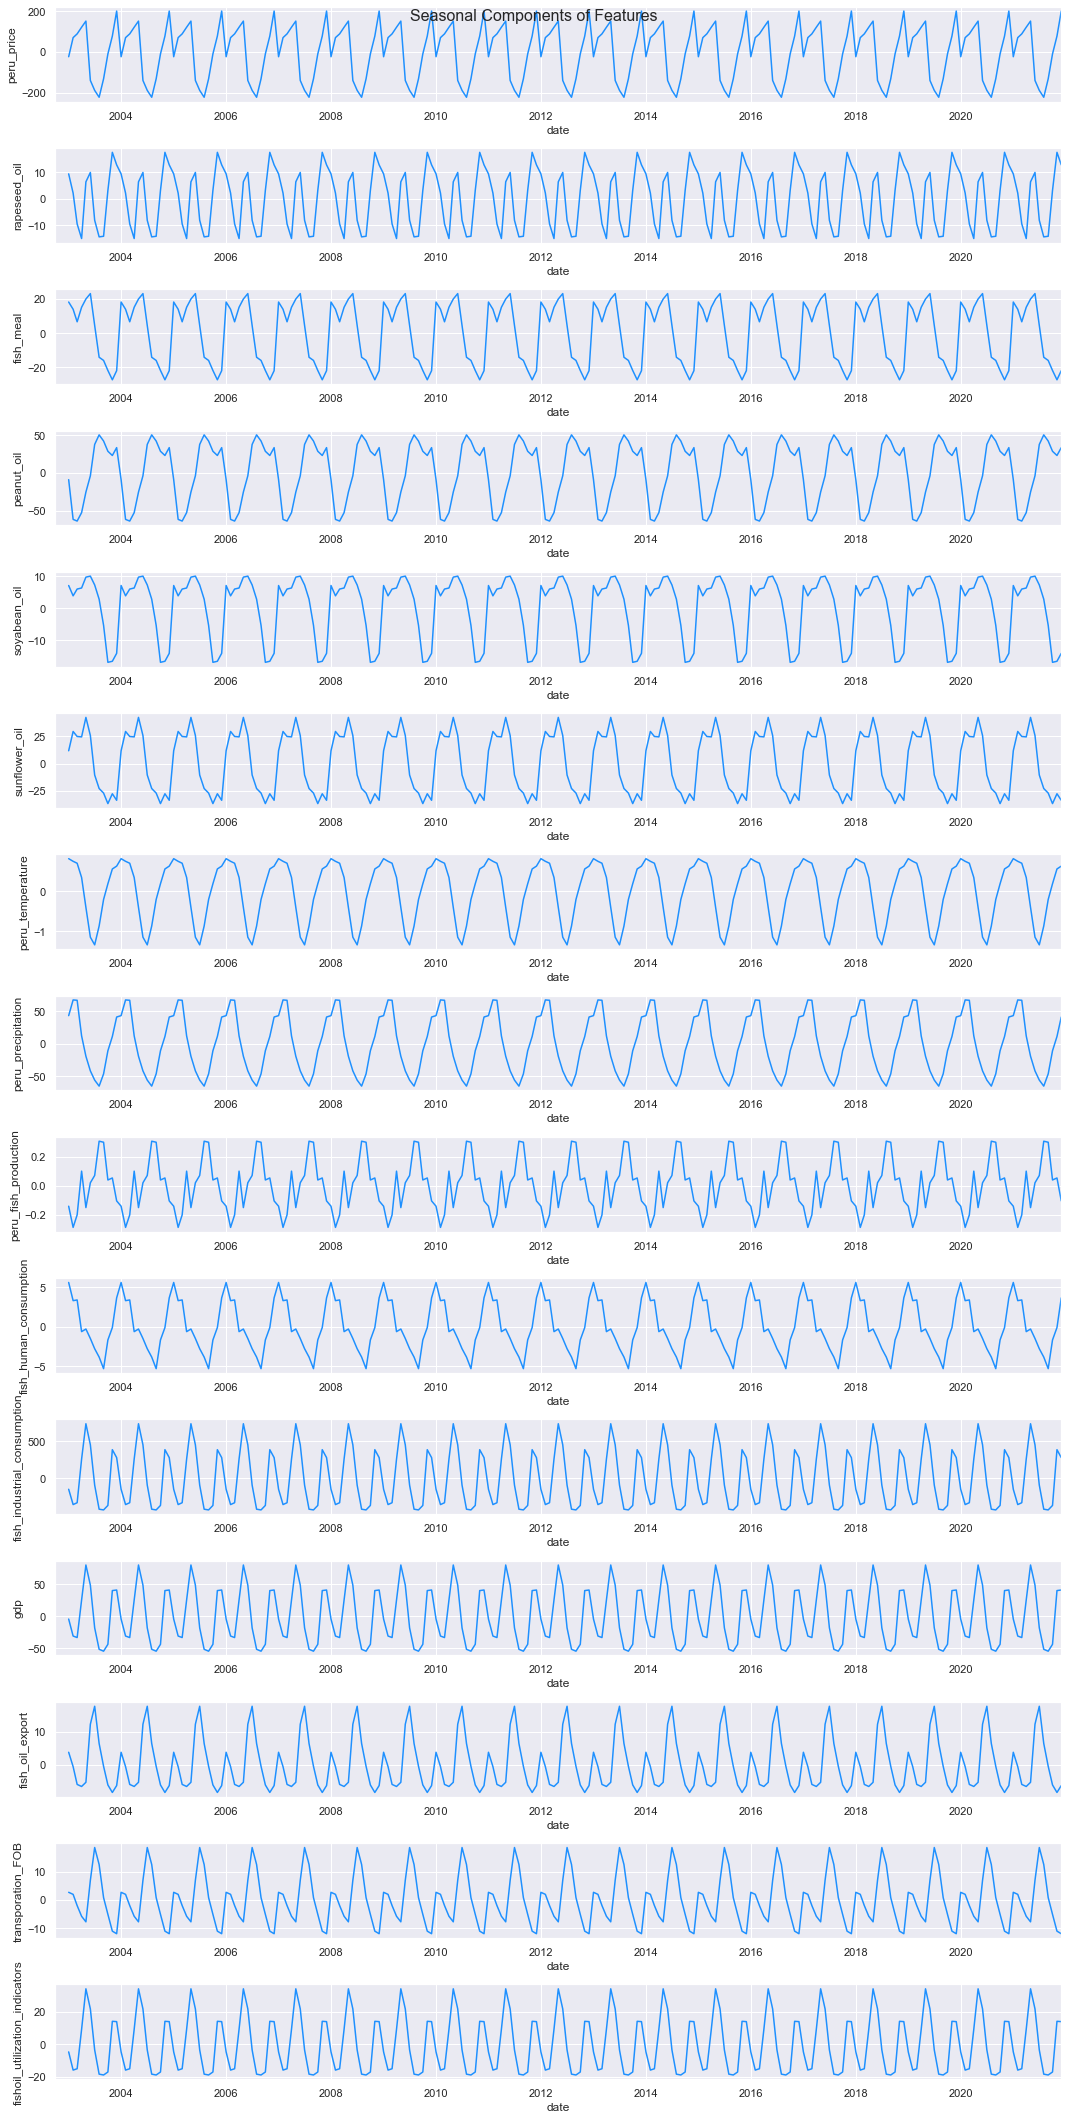

In [38]:
f, ax = plt.subplots(nrows=15, ncols=1, figsize=(15, 30))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_column):
    sns.lineplot(x=df.index, y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue')
    ax[i].set_ylabel(ylabel=column, fontsize=12)
    ax[i].set_xlim([date(2002, 10, 1), date(2021, 12,1 )])
    
plt.tight_layout()
plt.show()

In [39]:
'''
From above seasonality plot we could see following things:
1)Fish oil Peru Price - Price is maximum in November
                         Price is minimum around August
                        Increase in price is seen from January to June
2)Rapeseed Oil Price - Price is maximum in November
                        Price is minimum in March
3)Fish Meal Price- Price is maximum in Jan and June
                   Price is minimum in August
'''

'\nFrom above seasonality plot we could see following things:\n1)Fish oil Peru Price - Price is maximum in November\n                         Price is minimum around August\n                        Increase in price is seen from January to June\n2)Rapeseed Oil Price - Price is maximum in November\n                        Price is minimum in March\n3)Fish Meal Price- Price is maximum in Jan and June\n                   Price is minimum in August\n'

### Stationarity check

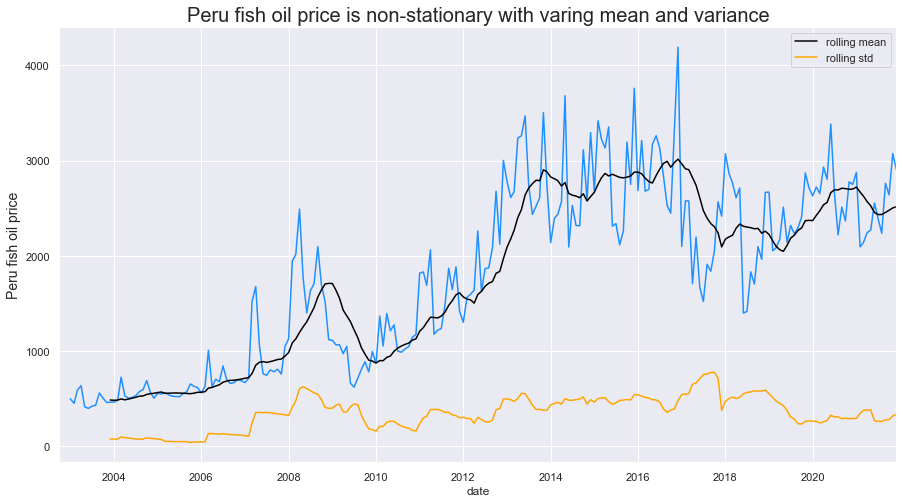

In [40]:
rolling_window = 12
plt.figure(figsize =(15,8) )
ax = sns.lineplot(x=df.index,y=df["peru_price"],color="dodgerblue")
ax = sns.lineplot(x=df.index,y=df["peru_price"].rolling(rolling_window).mean(),color="black", label="rolling mean")
ax = sns.lineplot(x=df.index, y=df["peru_price"].rolling(rolling_window).std(),color = "orange",label = "rolling std")
ax.set_title("Peru fish oil price is non-stationary with varing mean and variance", fontsize=20)
ax.set_ylabel(ylabel="Peru fish oil price", fontsize=14)
ax.set_xlim([date(2002,10,1),date(2021,12,1)])
plt.show()

#### Using Augmented Dickey-Fuller (ADF) to check stationarity

In [41]:
#Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

In [42]:
# Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).
# Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).
# If the null hypothesis can be rejected, we can conclude that the time series is stationary.

In [43]:
sm.tsa.stattools.adfuller(df["peru_price"])

(-1.6366090773053894,
 0.46403319232067197,
 4,
 223,
 {'1%': -3.460018927623594,
  '5%': -2.8745897386146817,
  '10%': -2.57372514086348},
 3121.9602240933687)

In [44]:
print("Diskey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df["peru_price"])[1])

Diskey-Fuller test: p=0.464033


In [45]:
#Since p value obtained from AD fuller test is above the significant level of 5% therefore we currently have a non-stationary data 

In [46]:
#checking ADfuller test for all the features in the dataframe and marking them acording to the color

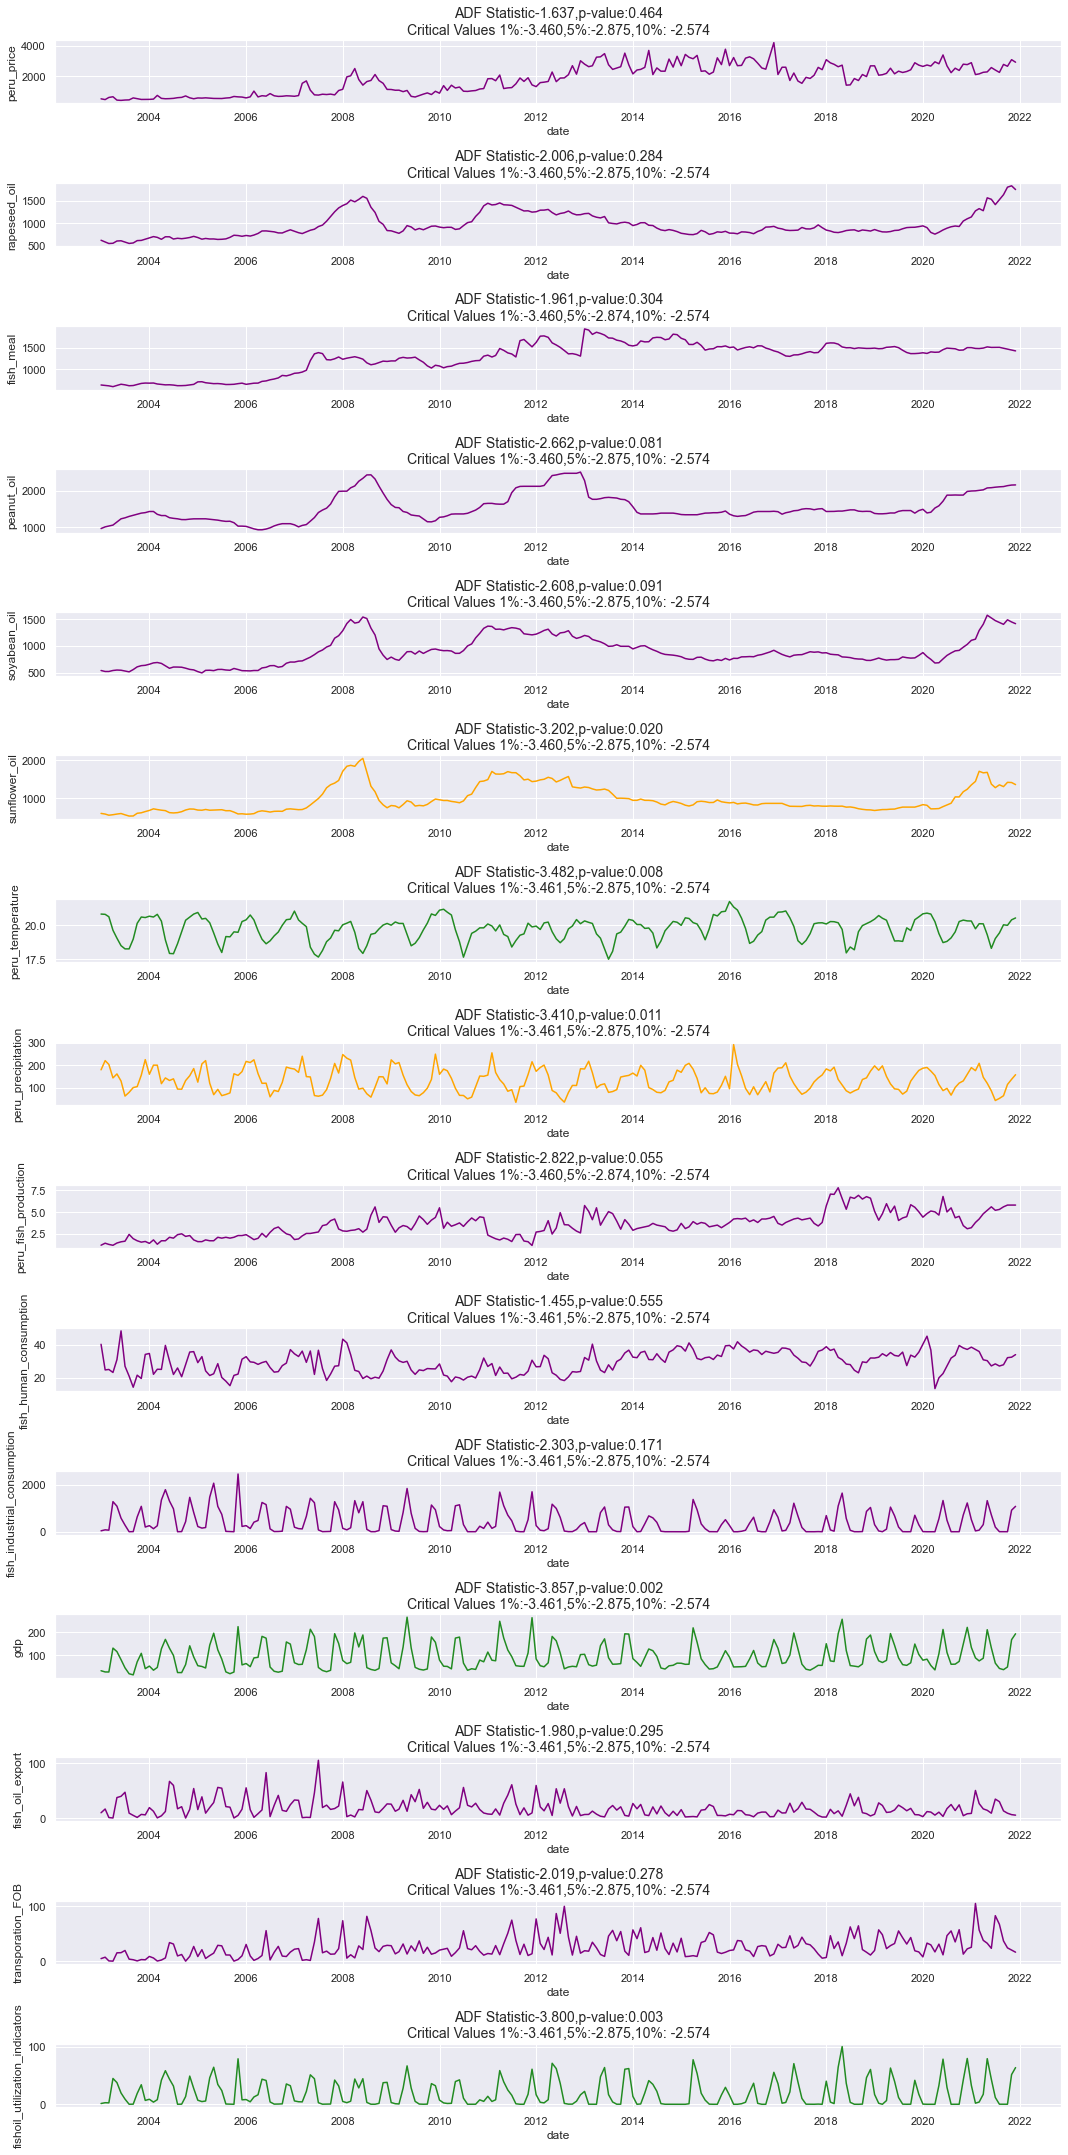

In [47]:
""""
Unit roots are a cause for non-stationarity.

    Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

    Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

Two conditions are getting checked

1) the null hypothesis can be rejected if the p-value is below a set significance level.
   The defaults significance level is 5%
2) the null hypothesis can be rejects if the test statistic is less than the critical value
On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

    **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    **p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

    **ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    **ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

"""""
f,ax=plt.subplots(nrows=15,ncols=1,figsize=(15,30))
def visualize_adfuller_results(series,title,ax):
    results = adfuller(series)
    significance_level = 0.05
    adf_stat = results[0]
    p_val=results[1]
    crit_val_1=results[4]["1%"]
    crit_val_5=results[4]["5%"]
    crit_val_10=results[4]["10%"]
    
    if (p_val < significance_level) & (adf_stat < crit_val_1):
        linecolor = "forestgreen"
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = "orange"
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = "red"
    else:
        linecolor = "purple"
    sns.lineplot(x=df.index,y = series, ax = ax,color = linecolor)
    ax.set_title(f'ADF Statistic{adf_stat:0.3f},p-value:{p_val:0.3f}\nCritical Values 1%:{crit_val_1:0.3f},5%:{crit_val_5:0.3f},10%: {crit_val_10:0.3f}',fontsize=14)
    ax.set_ylabel(ylabel=title,fontsize=12)
#visualize_adfuller_results(df["peru_price"].values, "Peru Fish Oil Price", ax[0,0])
for i, column in enumerate(core_column):
    visualize_adfuller_results(df[column].values, str(column) , ax[i])   
plt.tight_layout()
plt.show()

In [48]:
# from the above figure we could see that only peru tempertature,gdp and fish_oil_utilization data are stationary,
#so for rest of the data features we need to transform it so they also become stationary.

In [49]:
df = df[core_column]
df

peru_price  rapeseed_oil  fish_meal  peanut_oil  soyabean_oil  \
date                                                                        
2003-01-01       499.1        623.72     639.75      970.03        540.72   
2003-02-01       449.8        585.76     629.46     1016.45        522.43   
2003-03-01       589.4        551.92     620.43     1039.32        522.52   
2003-04-01       636.1        557.22     601.92     1064.23        540.90   
2003-05-01       414.2        607.17     630.09     1147.41        549.24   
...                ...           ...        ...         ...           ...   
2021-08-01      2237.2       1519.19    1504.12     2102.29       1433.94   
2021-09-01      2761.9       1629.14    1483.27     2109.02       1398.75   
2021-10-01      2641.1       1795.17    1461.66     2133.67       1483.52   
2021-11-01      3074.3       1825.34    1439.66     2150.21       1442.96   
2021-12-01      2907.3       1742.50    1422.52     2154.06       1411.21   

            sunflower_oil  peru_temperature  peru_precipitation  \
date                                                              
2003-01-01         612.00             20.85              179.45   
2003-02-01         595.00             20.83              220.07   
2003-03-01         565.00             20.65              203.28   
2003-04-01         578.00             19.64              143.62   
2003-05-01         595.00             19.05              161.21   
...                   ...               ...                 ...   
2021-08-01        1355.69             19.44               53.05   
2021-09-01        1309.52             20.05               64.80   
2021-10-01        1420.53             20.01              114.61   
2021-11-01        1415.62             20.42              137.36   
2021-12-01        1361.83             20.56              157.86   

            peru_fish_production  fish_human_consumption  \
date                                                       
2003-01-01                  1.19                   40.24   
2003-02-01                  1.42                   24.69   
2003-03-01                  1.28                   24.97   
2003-04-01                  1.18                   23.15   
2003-05-01                  1.44                   30.91   
...                          ...                     ...   
2021-08-01                  5.30                   27.05   
2021-09-01                  5.60                   27.83   
2021-10-01                  5.80                   32.12   
2021-11-01                  5.80                   32.41   
2021-12-01                  5.80                   33.97   

            fish_industrial_consumption     gdp  fish_oil_export  \
date                                                               
2003-01-01                        39.69   32.79            10.08   
2003-02-01                        80.92   27.52            16.85   
2003-03-01                        66.73   27.33             1.43   
2003-04-01                      1281.71  131.75             0.64   
2003-05-01                      1088.91  116.35            37.55   
...                                 ...     ...              ...   
2021-08-01                         2.53   42.79            30.12   
2021-09-01                         0.12   37.47            13.46   
2021-10-01                         1.26   49.26             9.30   
2021-11-01                       917.78  168.51             6.69   
2021-12-01                      1082.07  194.30             5.75   

            transporation_FOB  fishoil_utilization_indicators  
date                                                           
2003-01-01               5.03                            1.36  
2003-02-01               7.58                            2.71  
2003-03-01               0.84                            2.44  
2003-04-01               0.41                           44.74  
2003-05-01              15.55                           37.58  
...                     

## Transforming data to make it stationary

#### Using differentiation technique

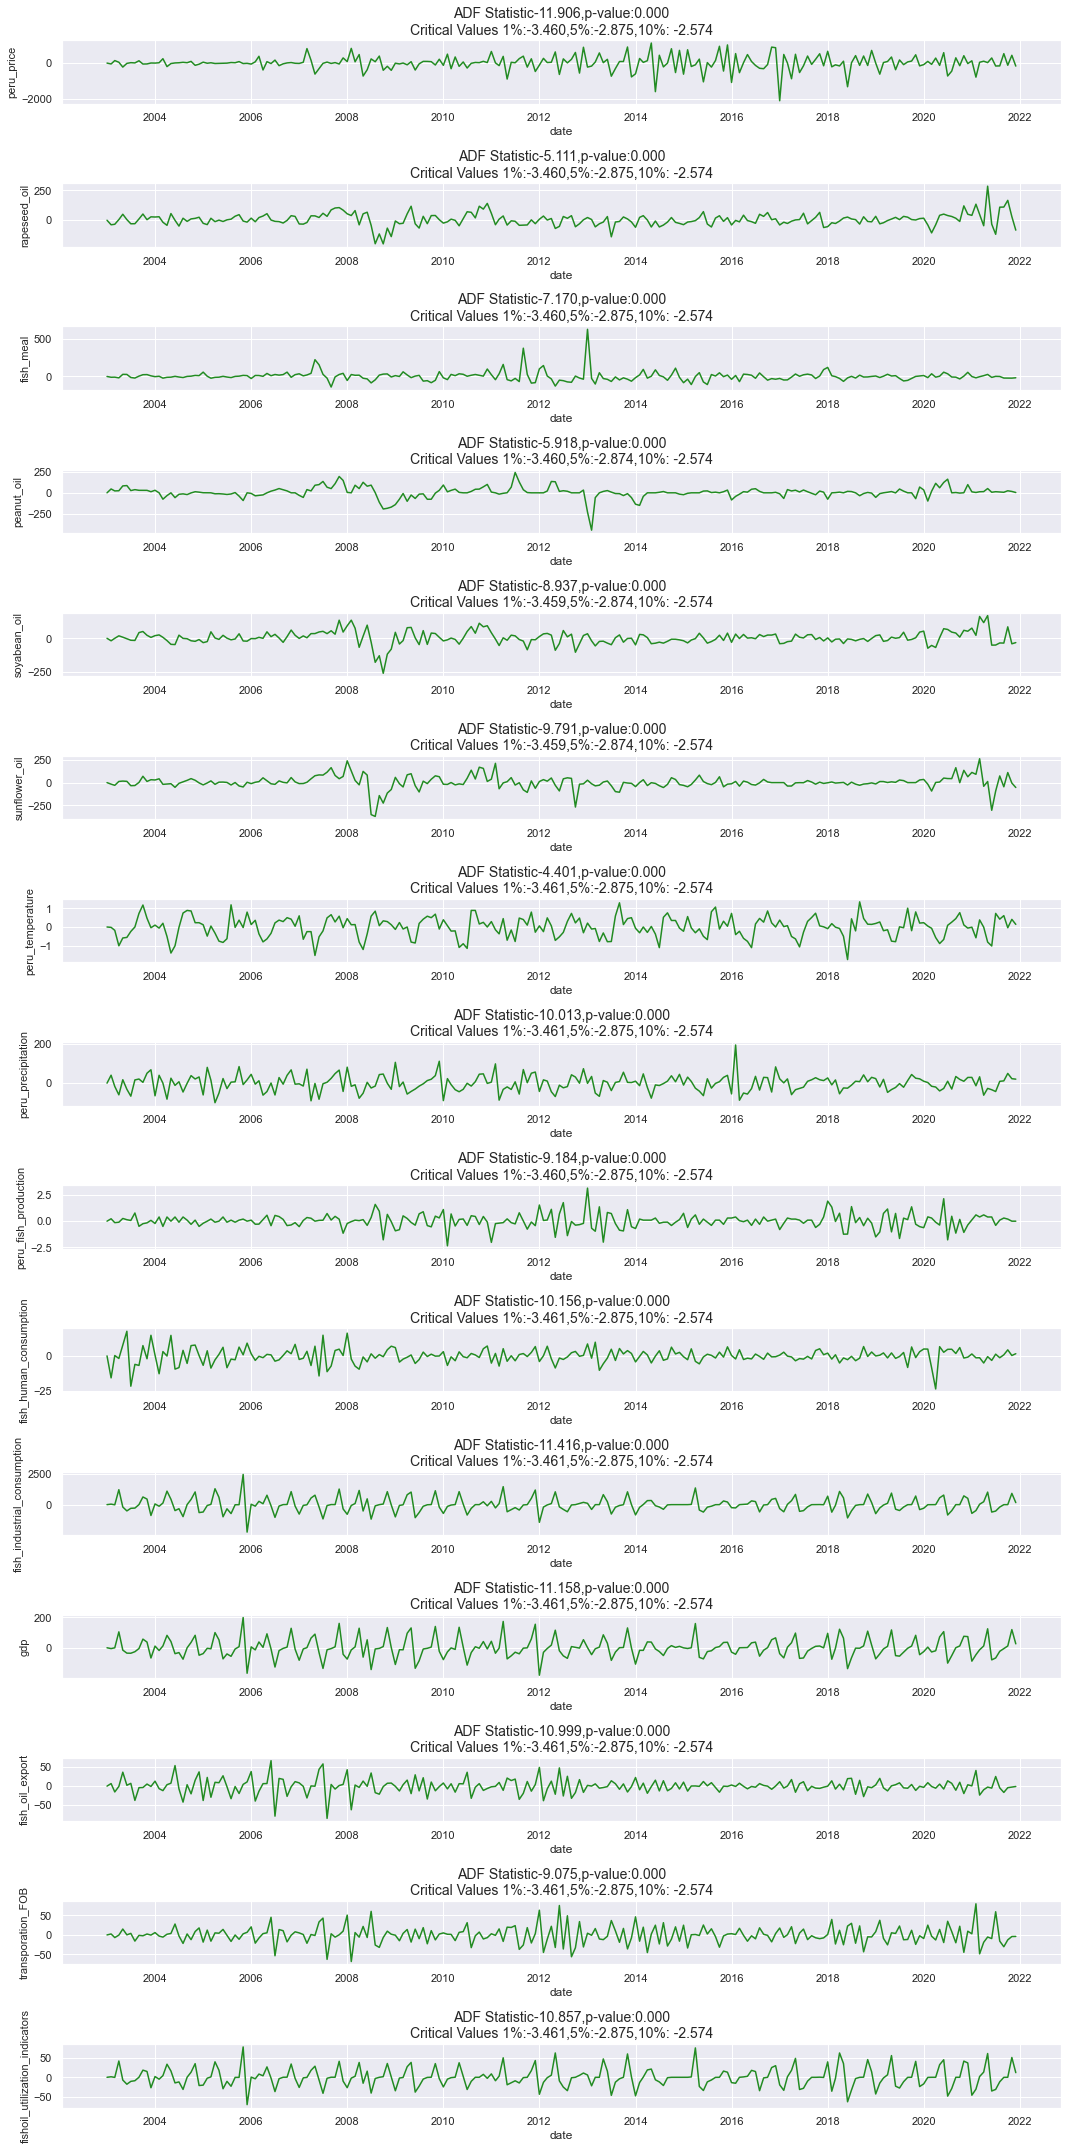

In [50]:
for i in df.columns:
    df[i] = np.append([0], np.diff(df[i]))
f, ax = plt.subplots(nrows=15, ncols=1, figsize=(15, 30))
for i,j in enumerate(df.columns):
    visualize_adfuller_results(df[j], "differenced", ax[i])
    ax[i].set_ylabel(ylabel=j , fontsize=11)
plt.tight_layout()
plt.show()  

In [52]:
df.columns

Index(['peru_price', 'rapeseed_oil', 'fish_meal', 'peanut_oil', 'soyabean_oil',
       'sunflower_oil', 'peru_temperature', 'peru_precipitation',
       'peru_fish_production', 'fish_human_consumption',
       'fish_industrial_consumption', 'gdp', 'fish_oil_export',
       'transporation_FOB', 'fishoil_utilization_indicators'],
      dtype='object')

####  Split the Series into Training and Testing Data

In [56]:
train_end = datetime(2017,12,1)
test_end = datetime(2021,12,1)
df_train = df[:train_end]
df_test = df[train_end + timedelta(days=1):test_end]
df_train.tail()

peru_price  rapeseed_oil  fish_meal  peanut_oil  soyabean_oil  \
date                                                                        
2017-08-01       391.9        -30.63      30.89       13.23         26.12   
2017-09-01       -72.7         -2.49      19.99       -5.52         27.72   
2017-10-01       210.3         24.38     -26.96      -23.54         -8.84   
2017-11-01       518.2         65.73       6.48       21.18          6.17   
2017-12-01      -150.6        -61.01      91.08        7.88        -19.58   

            sunflower_oil  peru_temperature  peru_precipitation  \
date                                                              
2017-08-01          22.74              0.30                9.44   
2017-09-01           6.50              0.51               17.37   
2017-10-01         -17.42              0.74               27.95   
2017-11-01           5.04              0.06               17.55   
2017-12-01          -9.10              0.01               13.15   

            peru_fish_production  fish_human_consumption  \
date                                                       
2017-08-01                   0.1                   -0.32   
2017-09-01                   0.1                   -2.15   
2017-10-01                  -0.6                    3.85   
2017-11-01                  -0.3                    5.06   
2017-12-01                   0.4                    0.85   

            fish_industrial_consumption    gdp  fish_oil_export  \
date                                                              
2017-08-01                      -179.26 -21.85           -12.20   
2017-09-01                        -1.62  -4.29            -0.42   
2017-10-01                         0.49   9.59            -5.22   
2017-11-01                         5.81  11.66            -5.97   
2017-12-01                        -6.36  -0.45            -2.78   

            transporation_FOB  fishoil_utilization_indicators  
date                                                           
2017-08-01             -11.97                           -9.95  
2017-09-01              -1.98                           -0.06  
2017-10-01              -7.26                           -0.07  
2017-11-01              -9.55                            0.31  
2017-12-01              -7.50                           -0.34

#### Selecting the Order (P) and (Q) of VARMA model

In [ ]:
test_results = {}

for p in range(5):
    for q in range(5):
        if p == 0 and q == 0:
            continue
            
        print(f'Testing Order: p = {p}, q = {q}')
        convergence_error = stationarity_error = 0
        
        try:
            model = VARMAX(df_train, order=(p,q), trend='n')
            model_result = model.fit(maxiter=1000, disp=False)
                
        except LinAlgError:
            convergence_error += 1
                
        except ValueError:
            stationarity_error += 1
                
        print('\nAIC:', model_result.aic)
        print('BIC:', model_result.bic)
        print('HQIC:', model_result.hqic)
        print('------------------------')

        test_results[(p, q)] = [model_result.aic,
                                model_result.bic,
                                convergence_error,
                                stationarity_error]

Testing Order: p = 0, q = 1

AIC: 24712.90318962407
BIC: 25814.473303181192
HQIC: 25159.542436082338
------------------------
Testing Order: p = 0, q = 2

AIC: 24757.126519521673
BIC: 26577.111924529094
HQIC: 25495.052231061418
------------------------
Testing Order: p = 0, q = 3

AIC: 25272.52585961478
BIC: 27810.926556072496
HQIC: 26301.738036236
------------------------
Testing Order: p = 0, q = 4

AIC: 25272.52585961478
BIC: 27810.926556072496
HQIC: 26301.738036236
------------------------
Testing Order: p = 1, q = 0

AIC: 24712.90318962407
BIC: 25814.473303181192
HQIC: 25159.542436082338
------------------------
Testing Order: p = 1, q = 1

AIC: 25196.310604963146
BIC: 27016.296009970567
HQIC: 25934.23631650289
------------------------
Testing Order: p = 1, q = 2

AIC: 25274.48109987848
BIC: 27812.881796336198
HQIC: 26303.693276499704
------------------------
Testing Order: p = 1, q = 3

AIC: 25787.193476343316
BIC: 29044.009464251332
HQIC: 27107.692118046016
---------------------

In [ ]:
test_results = pd.DataFrame(test_results).T
test_results.columns = ['AIC', 'BIC', 'convergence', 'stationarity']
test_results.index.names = ['p', 'q']
test_results.info()

In [ ]:
test_results.sort_values('AIC').head()

### Estimating with the best VARMA Model

In [ ]:
model = VARMAX(df_train, order=(1,0), trend='n').fit(maxiter=1000)
model.summary()